In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/602/DataForFinal/data_formodel.csv',index_col=0)
data.head()

,new/used,milage,price,brand year,fuel consumption min,fuel consumption max,drive mode_4WD,drive mode_AWD,drive mode_FWD,drive mode_RWD,...,brand_Mazda,brand_Mercedes-Benz,brand_Nissan,brand_Porsche,brand_RAM,brand_Subaru,brand_Toyota,brand_Volkswagen,brand_Volvo,brand_other
0,1,-6.649190e-01,38400.000000,-0.671587,-3.208156e-01,-0.035195,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,3.835387e-16,34637.216663,0.500749,6.173207e-16,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-5.721175e-01,32994.000000,0.735217,2.670508e-02,-0.035195,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-4.026447e-01,62500.000000,0.500749,-1.363378e+00,-1.365423,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-9.364972e-01,44995.000000,0.735217,6.173207e-16,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.shape

(154788, 50)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
X = data.loc[:,~data.columns.isin(['price'])]
y = data['price']
X_tensor = torch.tensor(X.values,dtype=torch.float32).to(device)
y_tensor = torch.tensor(y,dtype=torch.float32).unsqueeze(1).to(device)
dataset = TensorDataset(X_tensor,y_tensor)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train, val = torch.utils.data.random_split(dataset,[train_size, val_size])
train_dataloader = DataLoader(train, batch_size=train_size, shuffle=True)
val_dataloader = DataLoader(val, batch_size=val_size, shuffle=False)

In [ ]:
class Model(nn.Module):
  def __init__(self,input_size: int, output_size: int, drop_p: float):
    super().__init__()
    self.input = nn.Linear(input_size,128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(drop_p)
    self.layer_1 = nn.Linear(128,256)
    self.norm1 = nn.BatchNorm1d(256)
    self.layer_2 = nn.Linear(256,512)
    self.norm2 = nn.BatchNorm1d(512)
    self.layer_3 = nn.Linear(512,1024)
    self.norm3 = nn.BatchNorm1d(1024)
    self.layer_4 = nn.Linear(1024,512)
    self.norm4 = nn.BatchNorm1d(512)
    self.layer_5 = nn.Linear(512,256)
    self.norm5 = nn.BatchNorm1d(256)
    self.output = nn.Linear(256,output_size)
  def forward(self,X):
    X = self.input(X)
    X = self.layer_1(X)
    X_res1 = X
    X = self.norm1(X)
    X = self.relu(X)
    X = self.layer_2(X)
    X = self.norm2(X)
    X_res2 = X
    X = self.dropout(X)
    X = self.relu(X)
    X = self.layer_3(X)
    X = self.norm3(X)
    X = self.relu(X)
    X = self.layer_4(X)
    X = self.norm4(X)
    X = X + X_res2
    X = self.dropout(X)
    X = self.relu(X)
    X = self.layer_5(X)
    X = self.norm5(X)
    X = X + X_res1
    X = self.relu(X)
    X = self.output(X)
    return X

In [ ]:
def get_model():
  model = Model(X.shape[1],1,0)
  optimizer = optim.AdamW(model.parameters(),lr=0.02,weight_decay=0)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000, eta_min=0, last_epoch=-1, verbose=False)
  return model,optimizer,scheduler

model,opt,scheduler = get_model()
model = model.to(device)
loss_fn = nn.MSELoss()

In [ ]:
epoches = 2000
training_errors = []
test_errors = []
for batch in val_dataloader:
  X_test,y_test = batch

for epoch in range(epoches):
  for batch in train_dataloader:
    X_train,y_train = batch
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred,y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    model.eval()
    with torch.inference_mode():
      y_pred_test = model(X_test)
      loss_test = loss_fn(y_pred_test,y_test)
      loss = loss.cpu().numpy()
      loss_test = loss_test.cpu().numpy()
    scheduler.step()

    training_errors.append(np.log10(loss))
    test_errors.append(np.log10(loss_test))
  if epoch%50 == 0:
    print(f'epoch:{epoch} training loss = {np.log10(loss)},test loss = {np.log10(loss_test)}')

epoch:0 training loss = 9.484848022460938,test loss = 9.5321626663208
epoch:50 training loss = 9.215303421020508,test loss = 9.290000915527344
epoch:100 training loss = 9.195377349853516,test loss = 9.269281387329102
epoch:150 training loss = 9.184779167175293,test loss = 9.259315490722656
epoch:200 training loss = 9.175662994384766,test loss = 9.25273609161377
epoch:250 training loss = 9.160301208496094,test loss = 9.225996017456055
epoch:300 training loss = 9.14815902709961,test loss = 9.189255714416504
epoch:350 training loss = 9.113619804382324,test loss = 9.188393592834473
epoch:400 training loss = 9.037347793579102,test loss = 9.213704109191895
epoch:450 training loss = 8.976736068725586,test loss = 9.162004470825195
epoch:500 training loss = 8.900739669799805,test loss = 8.939314842224121
epoch:550 training loss = 8.844852447509766,test loss = 9.079914093017578
epoch:600 training loss = 8.801857948303223,test loss = 8.959667205810547
epoch:650 training loss = 8.76110553741455,te

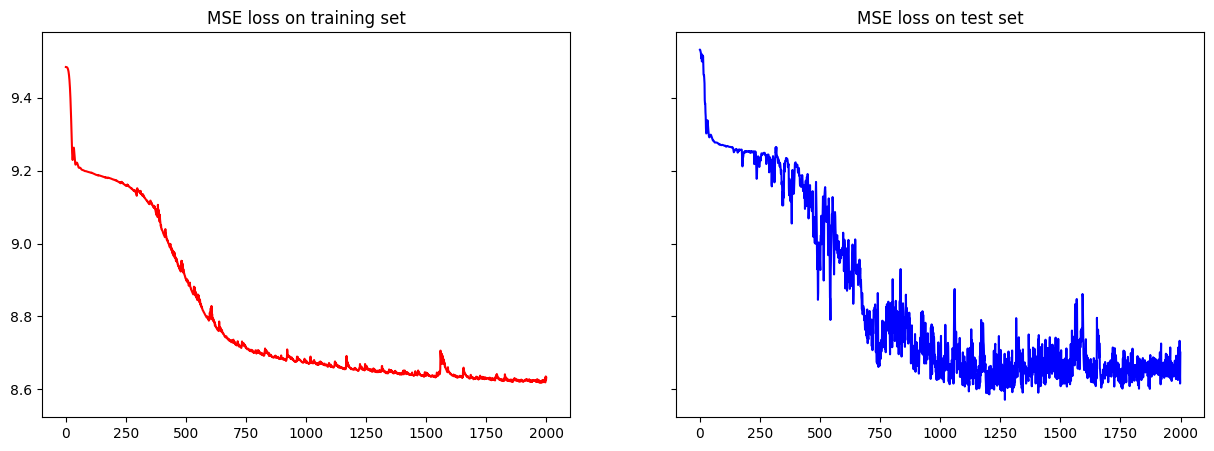

In [ ]:
figs, axes = plt.subplots(1,2,figsize=(15,5),sharey=True)
axes[0].plot(range(len(training_errors)),training_errors,color='red')
axes[1].plot(range(len(test_errors)),test_errors,color='blue')
axes[0].set_title('MSE loss on training set')
axes[1].set_title('MSE loss on test set')
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), r'/content/drive/MyDrive/602/DataForFinal/model_dict.pt')